In [185]:
import numpy as np
import matplotlib.pyplot as plt

In [186]:
from loaders import clean_text_for_pattern_letter
from temp_text_puh import template_str
# input_str = clean_text_for_pattern_letter(template_str, out_len=len(template_str))
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
input_str = '<' + input_str + '>'
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
           'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '<', '\'', '>']
print(f'{letters=}')
# print(f'{input_str=}')

len(letters)=32
502
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '<', "'", '>']


In [187]:
# generate SDR

SDR_len = 128 # 128
sparsity = 4 # 4
max_overlap = 1 # 1

sparse_prob = sparsity / SDR_len

letter_SDRs = {}

for letter in letters:
    while True:
        rnd_SDR = np.random.choice([0, 1], SDR_len, True, [1 - sparse_prob, sparse_prob])

        if (rnd_SDR > 0).sum() != sparsity:
            continue
        
        is_over_max = False
        for SDR in letter_SDRs.values():
            if (SDR & rnd_SDR).sum() > max_overlap:
                is_over_max = True
                break
        
        if is_over_max:
            continue
            
        break
    
    # print(f'{letter}')
    letter_SDRs.setdefault(letter, rnd_SDR)

for letter, SDR in letter_SDRs.items():
    print(f'{letter} : {(SDR > 0).sum()} {SDR.tolist()}')

a : 4 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
b : 4 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
c : 4 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [188]:
# text to SDRs
input_SDRs = []

for inp in input_str:
    input_SDRs.append(letter_SDRs[inp])

print(f'{len(input_SDRs)=}')

# for SDR in input_SDRs:
#     print(f'{SDR.tolist()}')

len(input_SDRs)=502


In [189]:
# init start column
column_size = 16

start_SDR = letter_SDRs['<']

start_I = np.zeros((start_SDR.size, column_size))

active_start_SDR_idx = np.where(start_SDR == 1)

for as_idx in active_start_SDR_idx[0]:
    rnd_active = np.random.randint(column_size)

    start_I[as_idx][rnd_active] = 1

# for col in np.rot90(start_I):
#     print(f'{col.astype(int).tolist()}')

In [190]:
# TODO: binary synapses, many orthogonal inputs per each neuron 

I = np.zeros((SDR_len, column_size))
# O = np.zeros((SDR_len, column_size))

ST=0.1
W = (np.random.rand(SDR_len, column_size, SDR_len * column_size) - 0.5) * 1e-2 + ST

V = np.zeros((SDR_len, column_size))

TR = np.zeros((SDR_len, column_size))

prec = 1e-30

TR_eps0 = 0.03 * 4 # 0.15

eps0_V = 0.09

infer_coef_TR = 0.8

epoch_cnt = 10
eps0 = 0.1

inc = 0.1
dec = 0.001

delta_TR = 0.1
coef_TR = 0.9

eps = eps0

for epoch_idx in range(epoch_cnt):
    I = np.copy(start_I)

    eps = (epoch_cnt - epoch_idx) * eps0
    print(f'{eps=}')

    for SDR in input_SDRs[1:]:
        rsh_I = I.reshape(SDR_len * column_size)

        win_col = np.where(SDR > 0)[0]

        win_row = []

        for w_idx in win_col:
            O = np.dot((W[w_idx] > ST), rsh_I)
            # print(f'{O.shape=}')

            win = 0
            if (O > TR[w_idx]).sum() > 0:
                O[O <= TR[w_idx]] = np.min(O)

                win = np.argmax(O)
            else:
                win = np.argmin(O)

            # print(f'{(O > 0).sum()=}')

            win_row.append(win)
            # print(f'{w_idx=} {win=}')
            # print(f'{(rsh_I == 0).sum()=} {(rsh_I == 1).sum()=}')
            W[w_idx][win] += rsh_I * inc * eps
            # print(f'{W[w_idx][win].tolist()=}')
            W[w_idx][win] += np.bitwise_not(rsh_I.astype('bool')) * (-dec) * eps
            # dW = np.bitwise_not(rsh_I.astype('bool')) * (-dec) * eps
            # print(f'{W[w_idx][win].tolist()=}')
            # print(dW.tolist())

            W[w_idx][win][W[w_idx][win] < 0] = 0
            W[w_idx][win][W[w_idx][win] > 1] = 1

            TR[w_idx][win] += (O[win] * coef_TR - TR[w_idx][win]) * delta_TR * eps

            V[w_idx][win] += 1

        win_row = np.array(win_row)

        # recur
        I.fill(0)
        I[(win_col, win_row)] = 1
        # print(f'{(I > 0).sum()=}')
        # print(f'{np.sum(I > 0, axis=1).tolist()=}')
        # print(f'{np.where(I > 0)=}')
        # print(f'{win_col=} {win_row=}')

W[V == 0] = 0

print(np.mean(V, axis=1).tolist())
print(np.sum(V > 0))
print(np.sum((V > 0), axis=1).tolist())
print((np.sum((V > 0), axis=1) > 0).sum())
print(f'{np.mean(TR[TR > 0])=} {TR.max()=} {TR.min()=}')
print(f'{np.mean(W[W > 0])=} {W.max()=} {W.min()=} {(W.size / (W > ST).sum())=}')
for i in np.sum((W > ST), axis=2).T:
    print(i.tolist())

eps=1.0
eps=0.9
eps=0.8
eps=0.7000000000000001
eps=0.6000000000000001
eps=0.5
eps=0.4
eps=0.30000000000000004
eps=0.2
eps=0.1
[0.625, 15.0, 49.375, 0.0, 1.875, 0.0, 2.5, 0.0, 0.0, 21.875, 5.625, 10.625, 33.75, 0.0, 16.875, 31.25, 5.625, 68.125, 0.0, 0.625, 0.0, 5.625, 5.0, 0.0, 61.875, 0.0, 0.0, 18.125, 6.875, 0.0, 0.0, 0.0, 2.5, 0.0, 0.0, 21.875, 83.125, 0.0, 0.0, 20.625, 0.625, 0.0, 7.5, 0.0, 0.0, 43.75, 0.0, 8.125, 21.875, 0.0, 5.0, 0.0, 4.375, 0.0, 0.0, 0.0, 41.875, 20.625, 0.0, 0.625, 6.875, 8.125, 0.0, 18.125, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.25, 0.0, 0.0, 4.375, 0.0, 25.0, 10.625, 0.0, 0.0, 0.0, 30.0, 5.625, 4.375, 13.75, 0.0, 0.0, 0.0, 8.125, 5.625, 0.0, 47.5, 0.0, 16.875, 0.625, 61.25, 0.0, 33.125, 0.0, 10.625, 18.125, 0.0, 53.75, 8.125, 0.0, 10.625, 13.125, 0.0, 0.0, 0.0, 20.0, 0.0, 44.375, 0.625, 7.5, 5.0, 0.0, 5.0, 6.875, 61.25, 0.0]
704
[1, 11, 16, 0, 3, 0, 3, 0, 0, 15, 7, 10, 16, 0, 15, 16, 7, 16, 0, 1, 0, 6, 7, 0, 16, 0, 0, 16, 8,

In [191]:
# test
error = []
over_mean_list = []
entropy_list = []
predictability_list = []
active_out_list = []

I = np.copy(start_I)

infer_coef_TR = 0.0

BW = (W > ST)
print(BW.shape, (BW > 0).sum())
print(BW[np.where(BW > 0)])

infer_TR = np.copy(TR)

for SDR in input_SDRs[1:]:
    rsh_I = I.reshape(SDR_len * column_size)

    O = np.dot(BW, rsh_I)
    OO = np.copy(O)
    # print(f'{O.tolist()=}')
    # print(f'{(O > TR * 0.1).sum()=}')

    # threshold
    if (O > TR).sum() >= sparsity:
        O[O <= TR] = np.min(O)
    # print(f'{(O > min_O).sum()=} {min_O=}')

    atr_O = np.copy(O)

    max_O = np.max(O, axis=1)
    argmax_O_idx = np.argsort(max_O)[::-1][:sparsity]

    SDR_O = np.zeros(O.shape[0])
    SDR_O[argmax_O_idx] = 1

    err = (SDR.astype(int) ^ SDR_O.astype(int)).sum()
    # print(f'{err=}')
    error.append(err)

    # dividers
    over_mean = (max_O > np.mean(max_O)).sum()
    over_mean_list.append(over_mean)

    max_OO = np.max(OO, axis=1)
    max_OO[max_OO <= 0] = prec
    entropy = np.copy(max_OO)
    entropy /= np.linalg.norm(entropy) + prec
    entropy[entropy < 0] = prec
    entropy = -1 * np.sum(entropy * np.log2(entropy))
    entropy_list.append(entropy)

    predictability = np.sum(np.abs(max_O - max_O[np.newaxis].T))
    predictability_list.append(predictability)

    active_out = np.sum(atr_O > TR)
    active_out_list.append(active_out)

    O *= SDR[np.newaxis].T
    max_O = np.max(O, axis=1)
    O[O < max_O[np.newaxis].T] = 0

    # recur
    O[O != 0] = 1

    I = np.copy(O)

error = np.array(error)
init_mean_percent = int(np.mean(error) / (2 * sparsity) * 100)
print(f'{np.mean(error)=} {error.max()=} {error.min()=} {init_mean_percent=}')

# O.shape
# for col in np.rot90(O):
#     print(f'{col.astype(int).tolist()}')

(128, 16, 2048) 7293
[ True  True  True ...  True  True  True]
np.mean(error)=0.16367265469061876 error.max()=6 error.min()=0 init_mean_percent=2


In [192]:
from numpy import ndarray

dividers: dict[str, ndarray] = {}

dividers.setdefault('error', np.array(error, dtype='float'))
dividers.setdefault('predictability', np.array(predictability_list, dtype='float'))
dividers.setdefault('over_mean', np.array(over_mean_list, dtype='float'))
dividers.setdefault('entropy', np.array(entropy_list, dtype='float'))
dividers.setdefault('active_out', np.array(active_out_list, dtype='float'))

# dividers['over_mean'] = 1 / dividers['over_mean']
# dividers['entropy'] = 1 / dividers['entropy']
# dividers['active_out'] = 1 / dividers['active_out']

for dv_key, dv in dividers.items():
    dividers[dv_key] = dv / np.max(np.abs(dv)) + prec


dv_key='error'


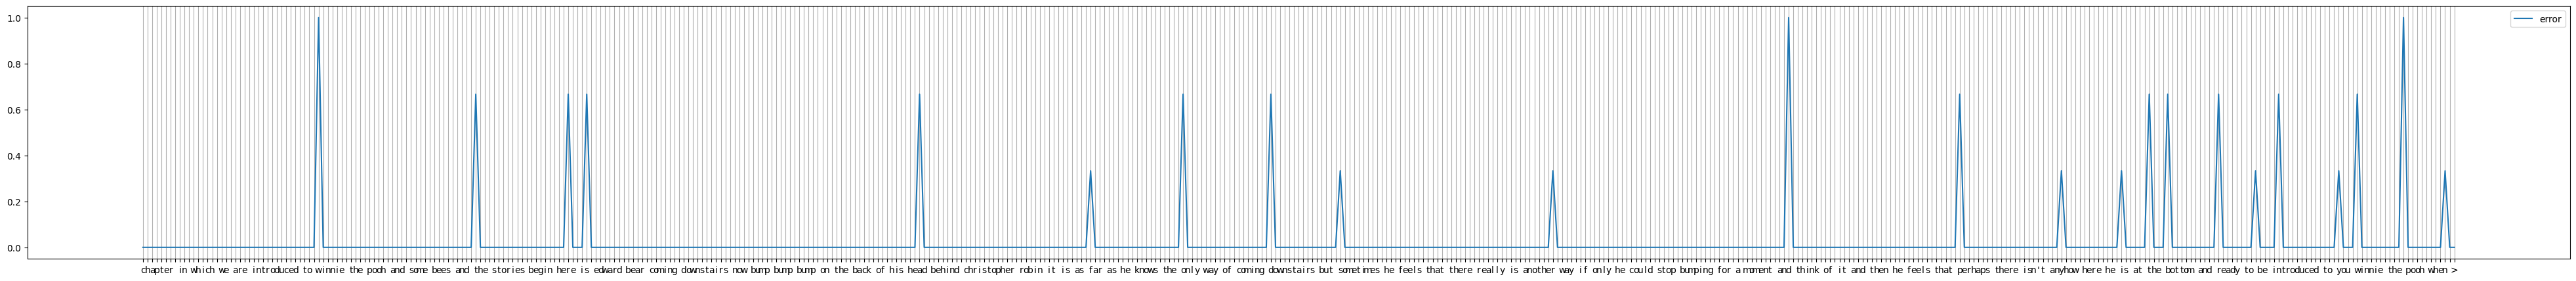

dv_key='predictability'


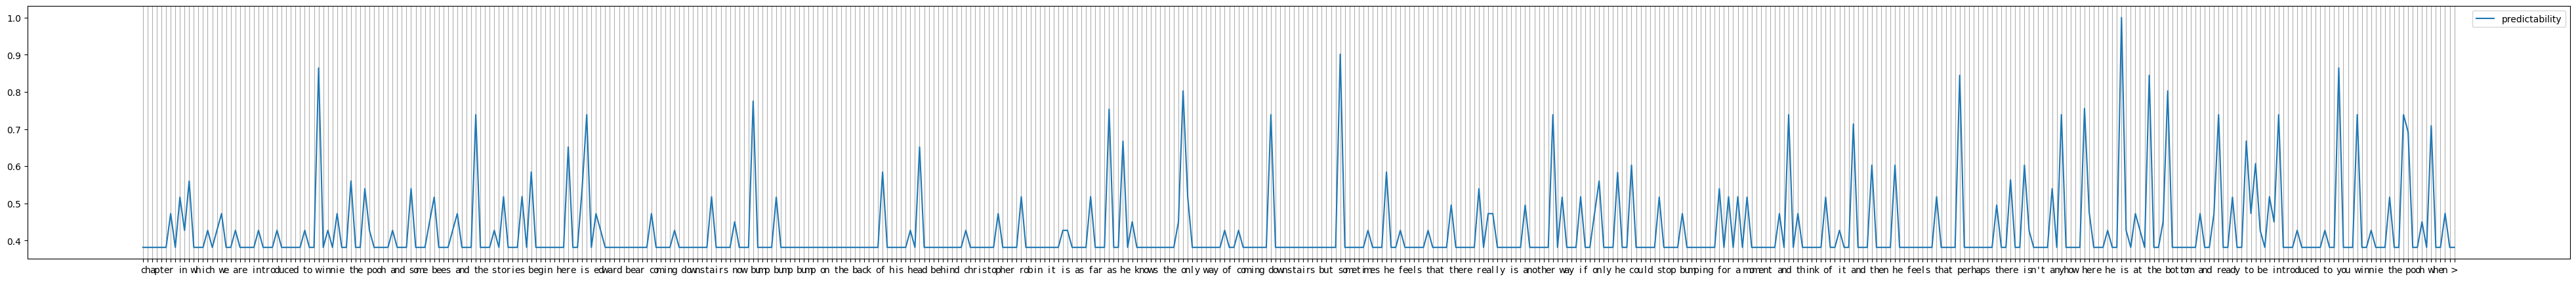

dv_key='over_mean'


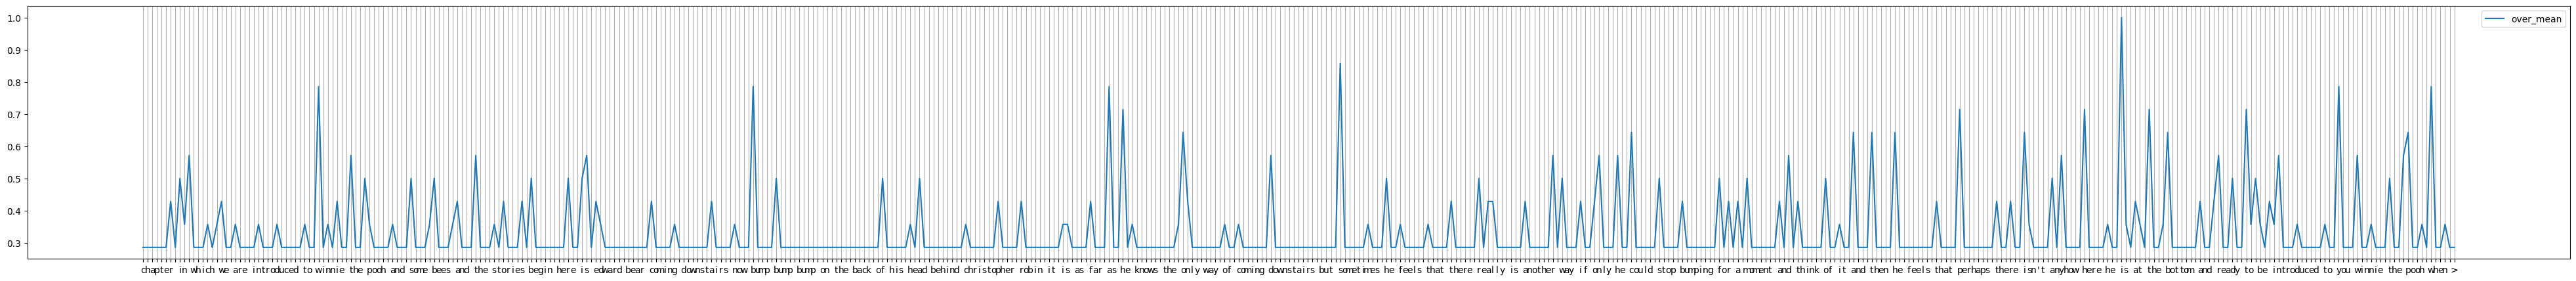

dv_key='entropy'


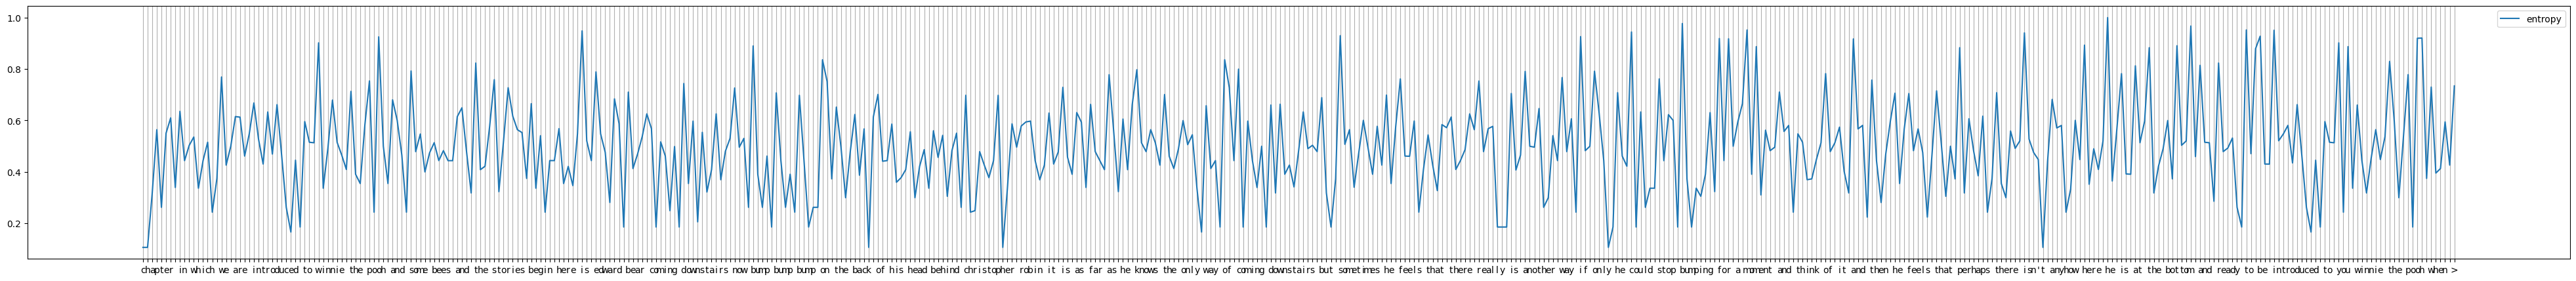

dv_key='active_out'


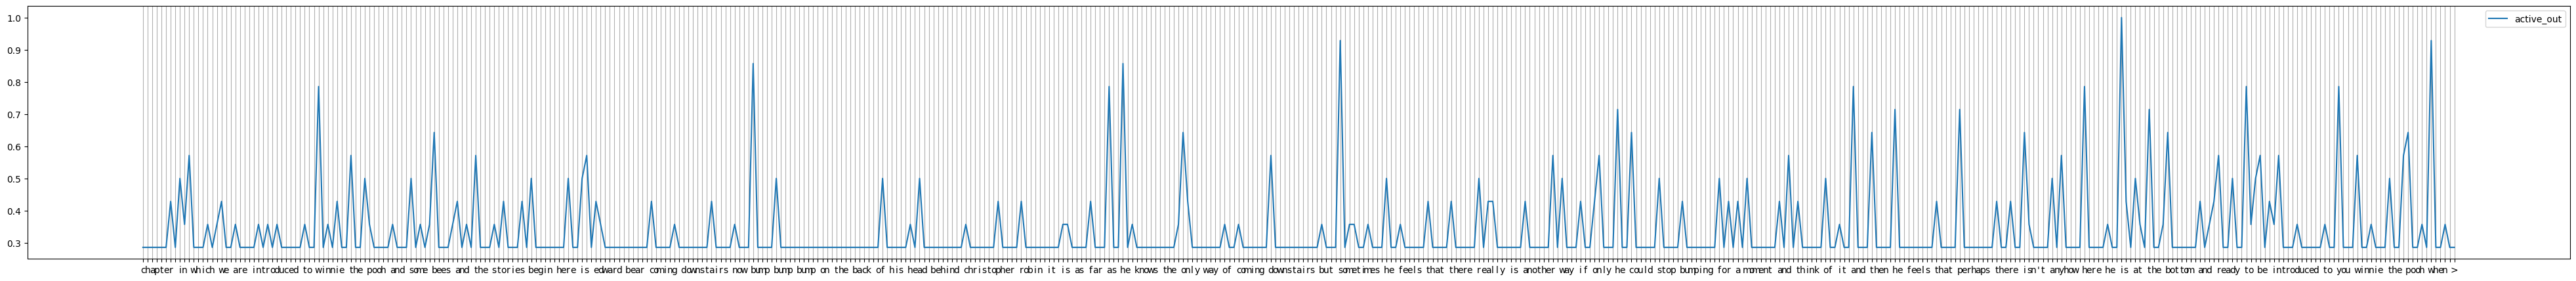

In [193]:
for dv_key, dv in dividers.items():
    plt.figure(figsize=(50, 5))

    plt.plot(np.arange(len(dv)), dv, label = dv_key)

    plt.xticks(np.arange(len(input_str[1:])), input_str[1:])
    plt.grid(visible=True, axis='x')

    plt.legend()
    print(f'{dv_key=}')
    plt.show()
    
    plt.close()

In [194]:
from numpy import ndarray

def get_diff_0(C: ndarray):
    return np.copy(C)

def get_diff_1(C: ndarray):
    return C - np.pad(C, (1, 0))[:-1]


def get_diff_2(C: ndarray):
    diff_C = get_diff_1(C)

    return diff_C - np.pad(diff_C, (1, 0))[:-1]


a = np.arange(1, 10)**2
print(a)
c = get_diff_1(a)
print(c)
c = get_diff_2(a)
print(c)


[ 1  4  9 16 25 36 49 64 81]
[ 1  3  5  7  9 11 13 15 17]
[1 2 2 2 2 2 2 2 2]


In [195]:
def divide_by_peak(C: ndarray, inputs: list, is_gt: bool = True):
    substrings: dict[str, int] = {}
    buffer = []

    peaks: dict[int, int] = {}

    for inp_idx, inp in enumerate(inputs):
        buffer.append(inp)

        if inp_idx == 0 or inp_idx >= len(inputs) - 2:
            continue

        C_idx = inp_idx # + 1

        if (is_gt and C[C_idx] > C[C_idx - 1] and C[C_idx] > C[C_idx + 1]) or \
                (not is_gt and C[C_idx] < C[C_idx - 1] and C[C_idx] < C[C_idx + 1]):
            substr = ''.join(buffer)

            substrings.setdefault(substr, 0)
            substrings[substr] += 1

            buffer = []

            peaks.setdefault(inp_idx, 1)

    # sort
    substrings = dict(sorted(substrings.items(), key=lambda item: item[1], reverse=True))

    peaks.setdefault((len(inputs) - 1), 1)

    return substrings, peaks


In [196]:
def divide_by_cliff(C: ndarray, inputs: list, is_gt: bool = True):
    substrings: dict[str, int] = {}
    buffer = []

    cliffs: dict[int, int] = {}

    for inp_idx, inp in enumerate(inputs):
        buffer.append(inp)

        if inp_idx == 0 or inp_idx >= len(inputs) - 1:
            continue

        C_idx = inp_idx # + 1

        if (is_gt and C[C_idx] > C[C_idx - 1]) or (not is_gt and C[C_idx] < C[C_idx - 1]):
            substr = ''.join(buffer)

            substrings.setdefault(substr, 0)
            substrings[substr] += 1

            buffer = []

            cliffs.setdefault(inp_idx, 1)

    # sort
    substrings = dict(sorted(substrings.items(), key=lambda item: item[1], reverse=True))

    cliffs.setdefault((len(inputs) - 1), 1)

    return substrings, cliffs


In [197]:
# generate dividers
get_diff_list = [get_diff_0, get_diff_1, get_diff_2]
divide_by_list = [divide_by_cliff, divide_by_peak]
gt_list = [True, False]

divide_idx: dict[str, dict[int, int]] = {}

dv_stats = {}
dv_stats_2 = {}

for dv_key, dv in dividers.items():
    for get_diff in get_diff_list: 
        for divide_by in divide_by_list:
            for gt in gt_list:
                temp_dv = get_diff(dv)
                substrings, dv_idx = divide_by(temp_dv, inputs=input_str, is_gt=gt)

                dv_idx_key = f'{dv_key}_{get_diff.__name__}_{divide_by.__name__}_gt={gt}'
                
                # sbs = np.array(list(substrings.values())).sum()
                sbs = np.mean(np.array(list(substrings.values()))) # / len(substrings)
                # sbs = 1 / len(substrings)
                # sbs = len(dv_idx) / len(substrings)

                # print(f'{dv_idx_key} : {sbs=}')
                dv_stats.setdefault(dv_idx_key, sbs)
                dv_stats_2.setdefault(dv_idx_key, len(substrings))

                divide_idx.setdefault(dv_idx_key, dv_idx)

# test
print(f'{len(divide_idx)=}')

dv_stats = dict(sorted(dv_stats.items(), key=lambda item: item[1], reverse=True))

for k, v in dv_stats.items():
    print(f'{k} : {v}')
    print(f'{k} : {dv_stats_2[k]}')
    print(f'{k} : {len(divide_idx[k])}')

for k, v in divide_idx.items():
    print(f'{k} : {len(divide_idx[k])} : {list(v.keys())}')

# 500
# predictability_get_diff_1_divide_by_cliff_gt=True
# 5 000
# predictability_get_diff_0_divide_by_cliff_gt=False : 8.095846645367413
# predictability_get_diff_0_divide_by_cliff_gt=False : 8.142857142857142
# predictability_get_diff_0_divide_by_cliff_gt=False : 7.867283950617284
# active_out_get_diff_1_divide_by_cliff_gt=True : 7.890804597701149
# 50 000
# over_mean_get_diff_1_divide_by_cliff_gt=True : 677
# entropy_get_diff_0_divide_by_cliff_gt=True : 629

len(divide_idx)=60
error_get_diff_0_divide_by_peak_gt=False : nan
error_get_diff_0_divide_by_peak_gt=False : 0
error_get_diff_0_divide_by_peak_gt=False : 1
entropy_get_diff_1_divide_by_cliff_gt=True : 2.282051282051282
entropy_get_diff_1_divide_by_cliff_gt=True : 117
entropy_get_diff_1_divide_by_cliff_gt=True : 268
entropy_get_diff_0_divide_by_cliff_gt=True : 2.208695652173913
entropy_get_diff_0_divide_by_cliff_gt=True : 115
entropy_get_diff_0_divide_by_cliff_gt=True : 255
entropy_get_diff_2_divide_by_cliff_gt=False : 2.065040650406504
entropy_get_diff_2_divide_by_cliff_gt=False : 123
entropy_get_diff_2_divide_by_cliff_gt=False : 255
entropy_get_diff_2_divide_by_cliff_gt=True : 1.968
entropy_get_diff_2_divide_by_cliff_gt=True : 125
entropy_get_diff_2_divide_by_cliff_gt=True : 247
entropy_get_diff_0_divide_by_cliff_gt=False : 1.9672131147540983
entropy_get_diff_0_divide_by_cliff_gt=False : 122
entropy_get_diff_0_divide_by_cliff_gt=False : 241
entropy_get_diff_1_divide_by_cliff_gt=False 

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [198]:
def get_upstream_input(input_SDRs: list[ndarray], divide_idx: dict[int, int]) -> list[ndarray]:
    buffer = []
    ups_inputs = []

    for SDR_idx, SDR in enumerate(input_SDRs):
        buffer.append(np.copy(SDR))

        if divide_idx.get(SDR_idx) or SDR_idx == len(input_SDRs) - 1:
            buffer = np.array(buffer)
            buffer = np.sum(buffer, axis=0)
            buffer[buffer > 1] = 1

            ups_inputs.append(buffer)

            buffer = []

    return ups_inputs

ups_inputs = get_upstream_input(input_SDRs, divide_idx=divide_idx['predictability_get_diff_0_divide_by_peak_gt=False'])

print(f'{len(ups_inputs)=}')
for ups_inp in ups_inputs:
    print((ups_inp == 1).sum(), ups_inp.size, ups_inp.tolist())

len(ups_inputs)=25
29 128 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
8 128 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]
24 128 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0

In [199]:
def train(ups_inputs: list[ndarray], 
          SDR_len = 128,
          push_delta=0.04,
          epoch_cnt=1,
          sparsity=4,
          eps0=0.01,
          eps0_V=0.09,
          EPS0=0.01,
          TR_coef=0.5,
          TR_eps0=0.01,
          ) -> tuple[ndarray, ndarray] :
    I = np.zeros(SDR_len)
    K = np.zeros(SDR_len)

    S = np.random.rand(SDR_len, SDR_len) * 1e-2

    V = np.zeros(SDR_len)

    TR = np.zeros(SDR_len)
    PO = np.zeros(SDR_len)

    prec = 1e-30

    inputs_idx = np.arange(len(ups_inputs))

    for epoch_idx in range(epoch_cnt):
        np.random.shuffle(inputs_idx)

        EPS = (epoch_cnt - epoch_idx) * EPS0

        for SDR_idx in inputs_idx:
            I = np.copy(ups_inputs[SDR_idx])

            K = np.dot(S, I)

            K /= np.max(np.abs(K)) + prec

            print(f'{(K >= TR * TR_coef).sum()=}')

            # threshold
            if (K >= TR * TR_coef).sum() > 0:
                K[K < TR * TR_coef] = np.min(K)

            # boosting
            nV = np.abs(V - np.max(V))
            nV /= np.max(nV) + prec

            OV = K + nV * eps0_V

            max_O_idx = np.argsort(OV)[::-1][:sparsity]
            pull_idx = max_O_idx[0]
            push_idx = max_O_idx[1:sparsity]

            # eps
            # eps = np.zeros(K.shape)
            # eps[max_O_idx] = eps0 * ((np.linalg.norm(S[max_O_idx], axis=1) - 1)**2)

            S[pull_idx] += (I - S[pull_idx] * K[pull_idx][np.newaxis].T) * EPS # eps[pull_idx][np.newaxis].T
            S[push_idx] += (I - S[push_idx] * K[push_idx][np.newaxis].T) * (-push_delta) * EPS # eps[push_idx][np.newaxis].T

            # threshold update
            TR[pull_idx] += (K[pull_idx] - TR[pull_idx] * PO[pull_idx]) * TR_eps0
            PO[pull_idx] = np.copy(K[pull_idx])

            # winners
            V[pull_idx] += 1

    print(f'{np.sum(V == 0)=}')

    return S, V, TR

In [200]:
def softmax(K: ndarray, t=0.01):
    eK = np.exp(K / t)
    
    return eK / np.sum(eK)

In [201]:
def softmax_train(ups_inputs: list[ndarray], 
          SDR_len = 128,
          push_delta=0.04,
          epoch_cnt=1,
          sparsity=4,
          eps0=0.01,
          EPS0=0.01,
          tmp=0.1,
          ) -> tuple[ndarray, ndarray] :
    I = np.zeros(SDR_len)
    K = np.zeros(SDR_len)

    S = np.random.rand(SDR_len, SDR_len) * 1e-2

    D = np.zeros(SDR_len)

    V = np.zeros(SDR_len)

    prec = 1e-30

    inputs_idx = np.arange(len(ups_inputs))

    for epoch_idx in range(epoch_cnt):
        np.random.shuffle(inputs_idx)

        EPS = (epoch_cnt - epoch_idx) * EPS0

        for SDR_idx in inputs_idx:
            I = ups_inputs[SDR_idx]

            K = np.dot(S, I)

            # K /= np.max(np.abs(K)) + prec

            SK = softmax(K, t=tmp)

            max_O_idx = np.argsort(SK)[::-1]
            D.fill(-1)
            D[max_O_idx[0]] = 1

            # eps
            # eps = np.zeros(K.shape)
            # eps[max_O_idx] = eps0 * ((np.linalg.norm(S[max_O_idx], axis=1) - 1)**2)

            S += D[np.newaxis].T * SK[np.newaxis].T * (I - S * K[np.newaxis].T) * EPS # eps[pull_idx][np.newaxis].T
            # S[push_idx] += (I - S[push_idx] * K[push_idx][np.newaxis].T) * (-push_delta) * EPS # eps[push_idx][np.newaxis].T
            
            # winners
            V[max_O_idx[0]] += 1

    print(f'{np.sum(V == 0)=}')
    print(f'{np.mean(S)=} {S.max()=} {S.min()=}')

    return S, V

In [202]:
# TODO: threshold learning - avg
# TODO: apical dendrite

def binary_train(ups_inputs: list[ndarray],
                 SDR_len=128,
                 push_delta=0.04,
                 epoch_cnt=1,
                 sparsity=4,
                 eps0=0.01,
                 ST=0.5,
                 infer_coef_TR=0.5,
                 train_coef_TR=0.5,
                 delta_TR=0.1,
                 increase=0.1,
                 decay=0.03,
                 min_S = 0.0,
                 max_S = 1.0,
                 ) -> tuple[ndarray, ndarray]:
    I = np.zeros(SDR_len)
    K = np.zeros(SDR_len, dtype='float')

    S = (np.random.rand(SDR_len, SDR_len) - 0.5) * 1e-2 + ST

    TR = np.zeros(SDR_len)

    V = np.zeros(SDR_len)

    inputs_idx = np.arange(len(ups_inputs))

    for epoch_idx in range(epoch_cnt):
        np.random.shuffle(inputs_idx)

        eps = (epoch_cnt - epoch_idx) * eps0

        for SDR_idx in inputs_idx:
            I = ups_inputs[SDR_idx]

            K = np.dot((S > ST), I)
            
            if (K > TR * infer_coef_TR).sum() >= sparsity:
                K[K <= TR * infer_coef_TR] = np.min(K)

            winr_idx = np.argsort(K)[::-1][:sparsity]
            pull_idx = winr_idx[0]

            S[pull_idx] += I * increase * eps * K[pull_idx][np.newaxis].T
            S[pull_idx] += np.bitwise_not(I.astype('bool')) * -decay * eps * K[pull_idx][np.newaxis].T

            S[S < min_S] = min_S
            S[S > max_S] = max_S

            TR[pull_idx] += (train_coef_TR * K[pull_idx] - TR[pull_idx]) * delta_TR * eps

            V[pull_idx] += 1

    print(f'{np.sum(V == 0)=}')
    print(f'{np.mean(S[S > 0])=} {np.median(S)=} {S.max()=} {S.min()=}')
    print(f'{np.mean(TR)=} {np.median(TR)=} {TR.max()=} {TR.min()=}')

    return S, V, TR


In [203]:
def get_SDRs(S: ndarray, 
             TR: ndarray, 
             ups_inputs: list[ndarray], 
             coef_TR=0.5,
             sparsity=4,
             ST=0.5,
             prec=1e-30,) -> tuple[list[ndarray], list[ndarray]]:
    SDRs = []
    Ks = []
    ds_Os = []

    for I in ups_inputs:
        K = np.dot((S > ST), I)

        if (K > TR * coef_TR).sum() >= sparsity:
            K[K <= TR * coef_TR] = np.min(K)
        
        Ks.append(np.copy(K))

        winners = np.argsort(K)[::-1][:sparsity]

        SDR = np.zeros(K.size)
        SDR[winners] = 1
        SDRs.append(SDR)

        ds_O = np.dot((S > ST).T, SDR)
        mean_ds_O = np.mean(ds_O)
        ds_O[ds_O < mean_ds_O] = 0
        ds_O[ds_O >= mean_ds_O] = 1
        ds_Os.append(ds_O)

    return SDRs, Ks, ds_Os


In [204]:
def context_predict(W: ndarray,
                    TR: ndarray,
                    ADrW: ndarray,
                    apl_TR: ndarray,
                    divide_idx: dict[int, int],
                    input_SDRs: list[ndarray],
                    start_I: ndarray,
                    ds_SDRs: list[ndarray],
                    ds_K: list[ndarray],
                    SDR_len = 128,
                    column_size = 32,
                    sparsity = 4,
                    ST=0.5,
                    apl_ST=0.1,
                    prec=1e-30,
                    ) -> list:
    error = []

    I = np.copy(start_I)

    iter_ds_SDRs = iter(ds_SDRs)
    ds_I = next(iter_ds_SDRs)

    bW = (W > ST)

    bDW = (ADrW > apl_ST)

    for SDR_idx, SDR in enumerate(input_SDRs[1:]):
        rsh_I = I.reshape(SDR_len * column_size)

        O = np.dot(bW, rsh_I)
        # print(f'{TR.shape=}')
        if (O > TR).sum() >= sparsity:
            O[O <= TR] = np.min(O)

        max_O = np.max(O, axis=1)

        # downstream
        if divide_idx.get(SDR_idx):
            ds_I = next(iter_ds_SDRs)

        ds_O = np.dot(bDW, ds_I)
        if (ds_O > apl_TR).sum() >= sparsity:
            ds_O[ds_O <= apl_TR] = np.min(ds_O)
        max_ds_O = np.max(ds_O, axis=1)

        # max_O /= np.max(np.abs(max_O)) + prec
        # max_ds_O /= np.max(np.abs(max_ds_O)) + prec
        
        max_O = max_O * max_ds_O

        # predicted SDR
        argmax_O_idx = np.argsort(max_O)[::-1][:sparsity]

        SDR_O = np.zeros(O.shape[0])
        SDR_O[argmax_O_idx] = 1

        err = (SDR.astype(int) ^ SDR_O.astype(int)).sum()
        # print(f'{err=}')
        error.append(err)

        O *= SDR[np.newaxis].T
        max_2_O = np.max(O, axis=1)
        O[O < max_2_O[np.newaxis].T] = 0

        # recur
        O[O != 0] = 1

        I = np.copy(O)
    
    return error


In [205]:
def apical_dendrite_predict_train(input_SDRs: list[ndarray],
                                  ds_SDRs: list[ndarray],
                                  divide_idx: dict[int, int],
                                  SDR_len=128,
                                  apl_dndr_size=8,
                                  epoch_cnt=10,
                                  eps0=0.1,
                                  ST=0.1,
                                  inc=0.1,
                                  dec=0.01,
                                  min_W=0.0,
                                  max_W=1.0,
                                    delta_TR = 0.1,
                                    coef_TR = 0.9,
                                  ):
    W = (np.random.rand(SDR_len, apl_dndr_size, SDR_len) - 0.5) * 1e-2 + ST

    V = np.zeros((SDR_len, apl_dndr_size))

    TR = np.zeros((SDR_len, apl_dndr_size))

    eps = eps0

    for epoch_idx in range(epoch_cnt):
        eps = (epoch_cnt - epoch_idx) * eps0
        print(f'{eps=}')

        iter_ds_SDRs = iter(ds_SDRs)
        ds_SDR = next(iter_ds_SDRs)

        for SDR_idx, SDR in enumerate(input_SDRs[1:]):
            if divide_idx.get(SDR_idx):
                ds_SDR = next(iter_ds_SDRs)

            win_col = np.where(SDR > 0)[0]

            win_row = []

            for w_idx in win_col:
                O = np.dot((W[w_idx] > ST), ds_SDR)

                win = 0
                if (O > TR[w_idx]).sum() > 0:
                    O[O <= TR[w_idx]] = np.min(O)

                    win = np.argmax(O)
                else:
                    win = np.argmin(O)

                win_row.append(win)
                W[w_idx][win] += ds_SDR * inc * eps
                W[w_idx][win] += np.bitwise_not(ds_SDR.astype('bool')) * (-dec) * eps

                W[w_idx][win][W[w_idx][win] < min_W] = min_W
                W[w_idx][win][W[w_idx][win] > max_W] = max_W

                TR[w_idx][win] += (O[win] * coef_TR - TR[w_idx][win]) * delta_TR * eps

                V[w_idx][win] += 1

    W[V == 0] = 0

    print(f'{np.mean(W[W > 0])=} {np.median(W)=} {W.max()=} {W.min()=}')
    print(f'{(V == 0).sum()=} / {V.size=} {V.size - (V == 0).sum()}')
    
    for i in np.sum((W > ST), axis=2).T:
        print(i.tolist())

    return W, TR


In [207]:
# test dividers
print(f'{np.mean(error)=} {error.max()=} {error.min()=} {init_mean_percent=}')

for dv_k in list(divide_idx.keys())[13:14]:
    dv = divide_idx[dv_k]
    print(f'{dv_k} : {len(dv)=}')

    ups_inputs = get_upstream_input(input_SDRs=input_SDRs, divide_idx=dv)

    bt_ST = 0.1
    infer_coef_TR = 1
    S, us_V, bt_TR = binary_train(ups_inputs=ups_inputs,
                                  SDR_len=SDR_len,
                                  push_delta=0.0,
                                  epoch_cnt=100,
                                  sparsity=sparsity,
                                  eps0=0.01,
                                  ST=bt_ST,
                                  infer_coef_TR=infer_coef_TR,
                                  train_coef_TR=0.95,
                                  delta_TR=0.1,
                                  increase=0.1,
                                  decay=0.02,
                                  min_S=0.0,
                                  max_S=1.0,
                                  )

    L2_SDRs, L2_Ks, ds_Os = get_SDRs(S=S,
                                     TR=bt_TR,
                                     coef_TR=infer_coef_TR,
                                     ST=bt_ST,
                                     ups_inputs=ups_inputs,
                                     sparsity=sparsity,
                                     )

    apl_ST = 0.1
    ADrW, apl_TR = apical_dendrite_predict_train(input_SDRs=input_SDRs,
                                                 ds_SDRs=L2_SDRs,
                                                 divide_idx=dv,
                                                 SDR_len=SDR_len,
                                                 apl_dndr_size=32,
                                                 epoch_cnt=10,
                                                 eps0=0.1,
                                                 ST=apl_ST,
                                                 inc=0.1,
                                                 dec=0.01,
                                                 min_W=0.0,
                                                 max_W=1.0,
                                                 delta_TR=0.1,
                                                 coef_TR=0.9,
                                                 )

    ctx_error = context_predict(W=W,
                                TR=infer_TR,
                                apl_TR=apl_TR,
                                ADrW=ADrW,
                                divide_idx=dv,
                                ds_SDRs=L2_SDRs,
                                ds_K=L2_Ks,
                                input_SDRs=input_SDRs,
                                start_I=start_I,
                                SDR_len=SDR_len,
                                column_size=column_size,
                                sparsity=sparsity,
                                ST=ST,
                                apl_ST=apl_ST,
                                )

    ctx_error = np.array(ctx_error)
    mean_percent = int(np.mean(ctx_error) / (2 * sparsity) * 100)
    print(f'{np.mean(ctx_error)=} {ctx_error.max()=} {ctx_error.min()=} {mean_percent=}')
    print(f'{np.mean(error) / np.mean(ctx_error) =}')

    print(f'------------')


np.mean(error)=0.16367265469061876 error.max()=6 error.min()=0 init_mean_percent=2
predictability_get_diff_0_divide_by_cliff_gt=False : len(dv)=116


np.sum(V == 0)=33
np.mean(S[S > 0])=0.3161679453433584 np.median(S)=0.0 S.max()=1.0 S.min()=0.0
np.mean(TR)=9.253858608879955 np.median(TR)=7.594376367067781 TR.max()=40.680350089871865 TR.min()=0.0
eps=1.0
eps=0.9
eps=0.8
eps=0.7000000000000001
eps=0.6000000000000001
eps=0.5
eps=0.4
eps=0.30000000000000004
eps=0.2
eps=0.1
np.mean(W[W > 0])=0.08351258589418555 np.median(W)=0.0 W.max()=1.0 W.min()=0.0
(V == 0).sum()=2961 / V.size=4096 1135
[0, 4, 9, 0, 0, 0, 4, 0, 0, 4, 4, 4, 4, 0, 4, 5, 4, 15, 0, 0, 0, 4, 4, 0, 9, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 13, 0, 0, 4, 0, 0, 0, 0, 0, 12, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 4, 4, 0, 0, 0, 7, 0, 0, 4, 0, 0, 0, 0, 0, 0, 16, 0, 4, 0, 19, 0, 11, 0, 0, 4, 0, 4, 0, 0, 4, 4, 0, 0, 0, 4, 0, 10, 0, 4, 4, 0, 4, 4, 14, 0]
[0, 4, 9, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 0, 4, 4, 0, 11, 0, 0, 0, 4, 4, 0, 9, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 12, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 4, 4, 0, 0, 0, 4, 0,